# SplitNN for the bank marketing dataset

- Active_party
    - Has model segment 1
    - Has first 10 features
    - Outsource label to Server for assisting computation
- Passive_party
    - Has model segment 2
    - Has last 10 features
- Server
    - Has model segment 3
    - Has sample labels

In [1]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from bank_dataset import BankDataset
import matplotlib.pyplot as plt

In [2]:
bank_set = BankDataset('dataset/bank_additional_full_filtered_balanced.csv')
print(bank_set, len(bank_set))

x0, y0 = bank_set[0]
print("example sample data: ", x0)
print("example sample label: ", y0)
print(x0.shape, y0.shape)

Len(samples): 7718 Positive labels sum: 3859.0
<bank_dataset.BankDataset object at 0x7f5eff2a25d0> 7718
example sample data:  tensor([2.3945e-01, 1.0009e-01, 1.0000e+00, 3.3344e-01, 1.0000e+00, 9.9900e-04,
        9.9900e-04, 9.9900e-04, 6.6670e-01, 5.0012e-01, 3.6697e-01, 2.9440e-02,
        1.0000e+00, 1.6664e-04, 5.0025e-01, 3.3347e-01, 2.6997e-01, 1.9250e-01,
        1.5730e-01, 5.1229e-01])
example sample label:  tensor(1.)
torch.Size([20]) torch.Size([])


In [3]:
# split the dataset into train_set and test_set
ratio = 0.2
test_len = int(len(bank_set) * ratio)
total_len = int(len(bank_set))
train_len = total_len - test_len

train_set, test_set = torch.utils.data.random_split(bank_set, [train_len, test_len])
print("len(train_set):", len(train_set))
print("len(test_set):", len(test_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)
print("len(train_loader):", len(train_loader))
print("len(test_loader):", len(test_loader))


len(train_set): 6175
len(test_set): 1543
len(train_loader): 97
len(test_loader): 25


In [4]:
import torch
from torch import nn, optim
import syft as sy
from splitnn_dataloader import SplitDataLoader

hook = sy.TorchHook(torch)

In [5]:
# create some workers
active_party = sy.VirtualWorker(hook, id="active_party")
passive_party = sy.VirtualWorker(hook, id="passive_party")
server = sy.VirtualWorker(hook, id= "server") 

data_parties = (active_party, passive_party)
model_locations = [active_party, passive_party, server]

### Create splitnn train loader

In [6]:
splitnn_train_loader = SplitDataLoader(data_parties=data_parties, data_loader=train_loader)
splitnn_test_loader = SplitDataLoader(data_parties=data_parties, data_loader=test_loader)

In [7]:
input_size= [10, 10]
hidden_sizes= {
    "active_party": [32, 16],
    "passive_party":[32, 16],
    "server":[16, 1]
}

# create model segment for each worker
models = {
    "active_party": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["active_party"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["active_party"][0], hidden_sizes["active_party"][1]),
                nn.ReLU(),
    ),
    "passive_party":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["passive_party"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["passive_party"][0], hidden_sizes["passive_party"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                # nn.ReLU(),
                # nn.Linear(hidden_sizes["server"][1], hidden_sizes["server"][2]),
                nn.Sigmoid()
    )
}


In [8]:
# create optimizers for each segment and link to their segment
optimizers = [
    optim.SGD(models[location.id].parameters(), lr=0.05,)
    for location in model_locations
]

# send model segment to each party and server
for location in model_locations:
    models[location.id].send(location)

In [9]:
def predict(data_pointer, models, data_parties, server):
    
    # individual party's output upto their respective cut layer
    parties_output = {}

    # outputs that is moved to server and subjected to concatenate for server input
    remote_outputs = []

    # iterate over each party and pass their inputs to respective
    # model segment and send outputs to server
    for party in data_parties:
        parties_output[party.id] = models[party.id](data_pointer[party.id])
        remote_outputs.append(
            parties_output[party.id].copy().move(server)
        )

    # aggregate outputs from all parties at server's location
    server_input = []
    for (j, output) in enumerate(remote_outputs):
        if j == 0:
            server_input = output
        else:
            server_input = torch.add(server_input, output)

    # pass concatenated output from server's model segment
    pred = models["server"](server_input)
    
    return pred

In [10]:
def test(models, dataloader, dataset_name):
    correct = 0
    with torch.no_grad():
        for data_ptr, label in dataloader:
            output = predict(data_ptr, models, data_parties, server).get()
            correct += ( (output > 0.5).squeeze() ).eq(label).sum().item()
    
    accuracy = 100. * correct / (len(dataloader) * 64)
    
    print("{}: Accuracy {}/{} ({}%)".format(dataset_name, 
                                            correct,
                                            len(dataloader) * 64,
                                            accuracy))
    return accuracy

In [11]:
def train(data_pointer, target, data_parties, models, optimizers, server):
    # make grads zero
    for opt in optimizers:
        opt.zero_grad()

    # individual party's output upto their respective cut layer
    parties_output = {}

    # outputs that is moved to server and subjected to concatenate for server input
    remote_outputs = []

    # iterate over each party and pass their inputs to respective
    # model segment and send outputs to server
    for party in data_parties:
        parties_output[party.id] = models[party.id](data_pointer[party.id])
        remote_outputs.append(
            parties_output[party.id].copy().move(server)
        )

    # concat outputs from all parties at server's location
    server_input = []
    for (j, output) in enumerate(remote_outputs):
        if j == 0:
            server_input = output
        else:
            server_input = torch.add(server_input, output)

    # pass concatenated output from server's model segment
    pred = models["server"](server_input)

    # compute loss
    criterion = torch.nn.BCELoss()
    loss = criterion(pred, target)

    # back-propagate
    loss.backward()

    # print("pred: ", pred)
    pred_get = pred.get()
    target_get = target.get()
    correct = ( (pred_get > 0.5).squeeze() ).eq(target_get).sum().item()
    total = pred_get.shape[0]

    for i, party in enumerate(data_parties):
        grads = remote_outputs[i].grad.copy().move(party)
        parties_output[party.id].backward(grads)

    # update the weights
    for opt in optimizers:
        opt.step()

    return loss.detach().get(), correct, total


### Train the NN model

In [12]:
epochs = 100

losses = []
train_accuracies = []
test_accuracies = []

for i in range(epochs):
    running_loss = 0
    train_correct = 0
    train_total = 0

    #iterate over each datapoints
    for data_ptr, label in splitnn_train_loader:

        #send labels to server's location for training
        label = label.send(server)

        loss, correct, total = train(data_ptr, label, data_parties, models, optimizers, server)
        running_loss += loss
        train_correct += correct
        train_total += total

    else:
        loss = (running_loss/len(train_loader)).item()
        print("Epoch {} - Training loss: {}".format(i, loss))
        # print("train_correct: ", train_correct)
        # print("train_total: ", train_total)
        # print("Epoch {} - Training accuracy: {}".format(i, train_correct/train_total))
        train_accuracy = test(models, splitnn_train_loader, "Train set")
        test_accuracy = test(models, splitnn_test_loader, "Test set")
        losses.append(loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

/usr/local/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  response = command_method(*args_, **kwargs_)


Epoch 0 - Training loss: 0.672577977180481
Train set: Accuracy 4414/6144 (71.84244791666667%)
Test set: Accuracy 1115/1536 (72.59114583333333%)
Epoch 1 - Training loss: 0.6415541768074036
Train set: Accuracy 4494/6144 (73.14453125%)
Test set: Accuracy 1141/1536 (74.28385416666667%)
Epoch 2 - Training loss: 0.5951734781265259
Train set: Accuracy 4467/6144 (72.705078125%)
Test set: Accuracy 1132/1536 (73.69791666666667%)
Epoch 3 - Training loss: 0.5628591179847717
Train set: Accuracy 4445/6144 (72.34700520833333%)
Test set: Accuracy 1130/1536 (73.56770833333333%)
Epoch 4 - Training loss: 0.550917387008667
Train set: Accuracy 4475/6144 (72.83528645833333%)
Test set: Accuracy 1133/1536 (73.76302083333333%)
Epoch 5 - Training loss: 0.5442378520965576
Train set: Accuracy 4510/6144 (73.40494791666667%)
Test set: Accuracy 1141/1536 (74.28385416666667%)
Epoch 6 - Training loss: 0.5379143953323364
Train set: Accuracy 4538/6144 (73.86067708333333%)
Test set: Accuracy 1156/1536 (75.26041666666667%

Text(0.5, 1.0, 'Testing Accuracy')

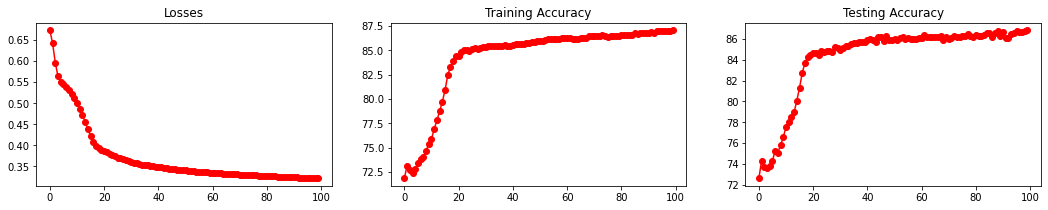

In [14]:
plt.figure(figsize=(18, 3))

plt.subplot(1, 3, 1)
plt.plot(range(len(losses)), losses, '-ro')
plt.title("Losses")
plt.subplot(1, 3, 2)
plt.plot(range(len(train_accuracies)), train_accuracies, '-ro')
plt.title("Training Accuracy")
plt.subplot(1, 3, 3)
plt.plot(range(len(test_accuracies)), test_accuracies, '-ro')
plt.title("Testing Accuracy")
plt.savefig("bank-splitnn.png")